In [1]:
scores = '../out/yeasts_scores.txt'

In [2]:
# plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

sns.set_style('white')

plt.rc('font', size=12)

In [3]:
# other imports
import numpy as np
import pandas as pd
from scipy import cluster
import fastcluster as fst
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

In [4]:
def plot_pca(pca, p,
             cstrains=None,
             rstrains=None,
             lstrains=None):
    if cstrains is None:
        cstrains = {}
    if rstrains is None:
        rstrains = {}
    if lstrains is None:
        lstrains = {}

    plt.figure(figsize=(10, 3))

    ax = plt.subplot(133)
    sns.barplot(data=[[x] for x in pca.explained_variance_ratio_[:6]],
                color=sns.xkcd_rgb['light grey'])

    plt.xticks(range(6),
               ['%d' % (x + 1)
                for x in range(6)])
    plt.xlabel('Principal component')
    plt.ylabel('Explained variance')

    sns.despine(ax=ax)

    for i in range(2):
        plt.subplot(1, 3, i+1)

        tmp = plt.plot(p.values[:, i],
                       p.values[:, i+1],
                       '.',
                       alpha=0.3,
                       color='k')
        for t in tmp:
            t.set_rasterized(True)
        for strain in ['Y8205',
                       'OS_693',
                       'OS_801',
                       'OS_104']:
            plt.plot(p.loc[strain].values[i],
                     p.loc[strain].values[i+1],
                     'o',
                     color=cstrains.get(rstrains.get(strain, ''),
                                        'k'),
                     ms=10,
                     label=lstrains.get(rstrains.get(strain, ''),
                                        rstrains.get(strain, '')))

        plt.xlabel('PC %d' % (i + 1))
        plt.ylabel('PC %d' % (i + 2))

        plt.axvline(0,
                    color='grey',
                    ls='dashed',
                    zorder=0)
        plt.axhline(0,
                    color='grey',
                    ls='dashed',
                    zorder=0)

        if i == 1:
            lg = plt.legend(loc=(1.85, 0.55),
                            frameon=True,
                            title='Strain',
                            ncol=1)
            for x in lg.legendHandles:
                lg.set_alpha(1)

    plt.subplots_adjust(hspace=0.3,
                        wspace=0.3);

In [5]:
strains = ['S288C', 'Y55',
           'UWOP', 'YPS']
rstrains = {'Y8205': 'S288C',
            'OS_801': 'Y55',
            'OS_693': 'UWOP',
            'OS_104': 'YPS'}
lstrains = {'S288C': 'Y8205',
            'YPS': 'YPS128'}
cstrains = {x: c
            for x, c in zip(strains, sns.color_palette('Set1', len(strains)))}

In [6]:
m = pd.read_table(scores, index_col=[0, 1]).sort_index()
m['phenotype'] = m['qvalue'] < 0.05
m['pos-phenotype'] = (m['qvalue'] < 0.05) & (m['score'] > 0)
m['neg-phenotype'] = (m['qvalue'] < 0.05) & (m['score'] < 0)
p = m.pivot_table(index='strain',
                  columns='condition',
                  values='score')

In [7]:
c = p.copy(deep=True)
c[np.isnan(c)] = 0.
rl = fst.linkage(c, method='average')
cl = fst.linkage(c.T, method='average')
cmap = sns.diverging_palette(76, 217, l=89, n=100, center="dark", as_cmap=True)
cmap.set_bad(sns.xkcd_rgb['grey'], alpha=0.55)

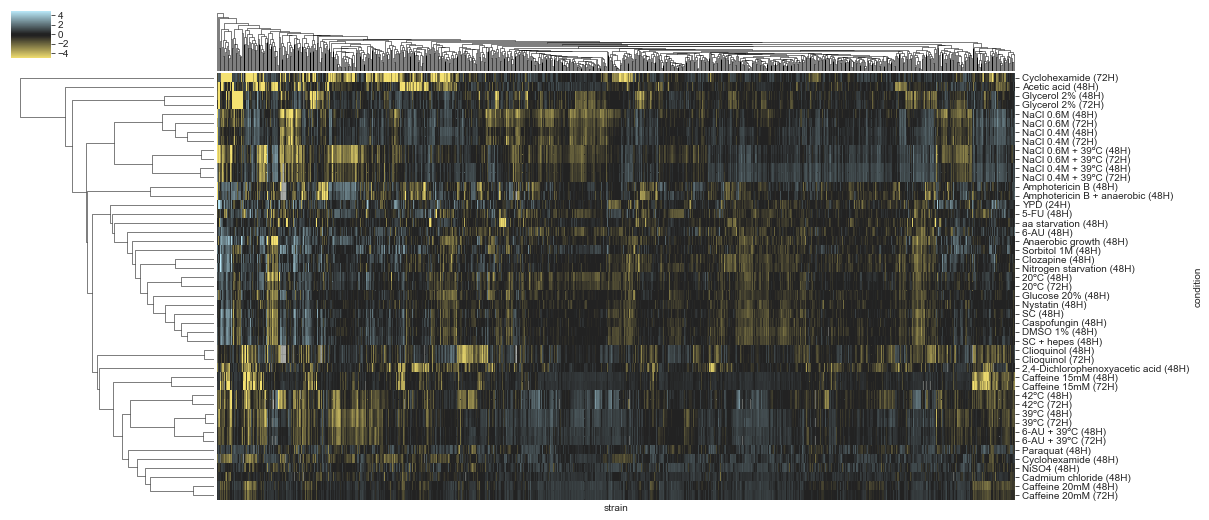

In [8]:
mclust = sns.clustermap(p.T,
                        cmap=cmap,
                        vmax=5,
                        vmin=-5,
                        xticklabels=False,
                        yticklabels=True,
                        row_linkage=cl,
                        col_linkage=rl,
                        figsize=(18, 9));

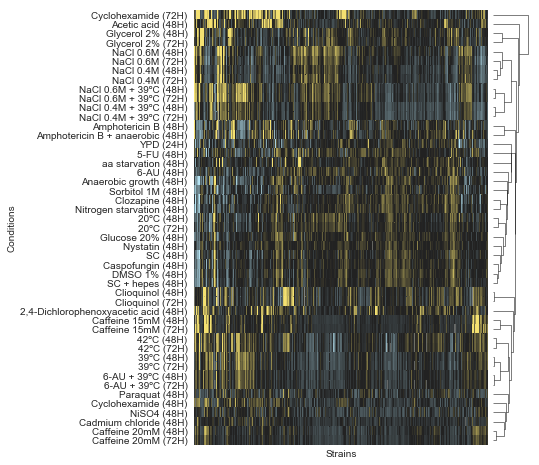

In [9]:
plt.figure(figsize=(6, 8))

gs = plt.GridSpec(1, 2,
                  wspace=0.025,
                  width_ratios=[8, 1])

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

plt.sca(ax1)
yticklabels = True
hm = sns.heatmap(mclust.data2d,
                 cmap=cmap,
                 vmax=4,
                 vmin=-4,
                 yticklabels=yticklabels,
                 xticklabels=False,
                 cbar=False)
plt.xlabel('Strains')
ax1.collections[0].set_rasterized(True)
plt.ylabel('Conditions')
plt.yticks(rotation=0)

plt.sca(ax2)
with plt.rc_context({'lines.linewidth': 0.5}):
    cluster.hierarchy.dendrogram(cl, no_plot=False,
                                 color_threshold=-np.inf,
                                 above_threshold_color='k',
                                 orientation='right',
                                 no_labels=True)
plt.xticks([])
plt.gca().invert_yaxis()

sns.despine(bottom=True,
            left=True)

plt.savefig('heatmap_natural.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('heatmap_natural.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);

In [10]:
pca1 = PCA().fit(c)
p1 = pd.DataFrame(pca1.transform(c),
                  index=p.index)

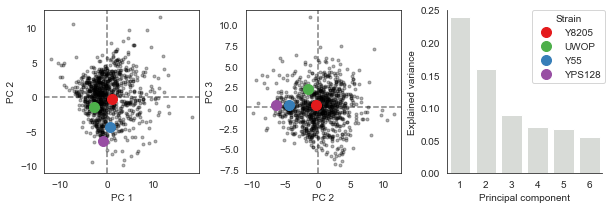

In [11]:
plot_pca(pca1, p1,
         cstrains=cstrains,
         rstrains=rstrains,
         lstrains=lstrains)
plt.savefig('pca_natural.png',
            dpi=300, bbox_inches='tight',
            transparent=True)
plt.savefig('pca_natural.svg',
            dpi=300, bbox_inches='tight',
            transparent=True);